In [42]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import glob
import cv2
import numpy as np
from sklearn.metrics.pairwise import *
from sklearn.metrics import accuracy_score

In [43]:
# 1) Define paths to your folders (relative or absolute).
good_imgs_path = 'train/good'
bad_imgs_path  = 'train/bad'

# 2) Create empty lists for images and labels.
X = []
y = []

# 3) Load 'good' images.
for file_path in glob.glob(os.path.join(good_imgs_path, "*.png")):
    # Read image with OpenCV (BGR format).
    img = cv2.imread(file_path)
    
    # Optional: resize if you have a fixed input size for your model.
    # Example: resize to 128x128
    img = cv2.resize(img, (128, 128))
    
    # Convert from BGR to RGB if desired (some frameworks assume RGB).
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to float and normalize (0..1).
    img = img.astype("float32") / 255.0
    
    # Append to list.
    X.append(img)
    y.append(1)  # Label for good images.

# 4) Load 'bad' images.
for file_path in glob.glob(os.path.join(bad_imgs_path, "*.png")):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0
    
    X.append(img)
    y.append(-1)  # Label for bad images.

# 5) Convert lists to NumPy arrays.
X = np.array(X, dtype="float32")
y = np.array(y, dtype="int")

print("X shape:", X.shape)
print("y shape:", y.shape)

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),          # Resize to match your CNN input
    transforms.ToTensor(),                  # Converts to tensor with shape [C, H, W], scales 0-1
    # transforms.Normalize([0.5], [0.5])    # Optional: normalize to [-1, 1] if needed
])

# Load dataset
dataset = datasets.ImageFolder(root='train', transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check class indices (you'll get 0 for 'bad', 1 for 'good')
print(dataset.class_to_idx)  # {'bad': 0, 'good': 1}

# Sample batch
images, labels = next(iter(dataloader))
print(images.shape)  # should be [32, 3, 128, 128]
print(labels)


X shape: (84, 128, 128, 3)
y shape: (84,)
{'bad': 0, 'good': 1}
torch.Size([32, 3, 128, 128])
tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 1])


In [44]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder: reducing spatial dimensions with conv layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # [B, 16, 64, 64]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # [B, 128, 8, 8]
            nn.ReLU()
        )
        # Decoder: reconstructing the original dimensions
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # [B, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [B, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [B, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),   # [B, 3, 128, 128]
            nn.Sigmoid()  # Optional: to scale outputs between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [45]:
model = ConvAutoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8)

Epoch 1/100, Loss: 0.241354
Epoch 2/100, Loss: 0.241914
Epoch 3/100, Loss: 0.241091
Epoch 4/100, Loss: 0.240815
Epoch 5/100, Loss: 0.240521
Epoch 6/100, Loss: 0.240854
Epoch 7/100, Loss: 0.240343
Epoch 8/100, Loss: 0.240832
Epoch 9/100, Loss: 0.240044
Epoch 10/100, Loss: 0.238955
Epoch 11/100, Loss: 0.240043
Epoch 12/100, Loss: 0.239595
Epoch 13/100, Loss: 0.239098
Epoch 14/100, Loss: 0.239449
Epoch 15/100, Loss: 0.237669
Epoch 16/100, Loss: 0.237388
Epoch 17/100, Loss: 0.236721
Epoch 18/100, Loss: 0.237116
Epoch 19/100, Loss: 0.234537
Epoch 20/100, Loss: 0.233340
Epoch 21/100, Loss: 0.230266
Epoch 22/100, Loss: 0.226014
Epoch 23/100, Loss: 0.220970
Epoch 24/100, Loss: 0.213459
Epoch 25/100, Loss: 0.203303
Epoch 26/100, Loss: 0.192175
Epoch 27/100, Loss: 0.179716
Epoch 28/100, Loss: 0.167574
Epoch 29/100, Loss: 0.155793
Epoch 30/100, Loss: 0.144683
Epoch 31/100, Loss: 0.133503
Epoch 32/100, Loss: 0.123438
Epoch 33/100, Loss: 0.113211
Epoch 34/100, Loss: 0.104370
Epoch 35/100, Loss: 0.0

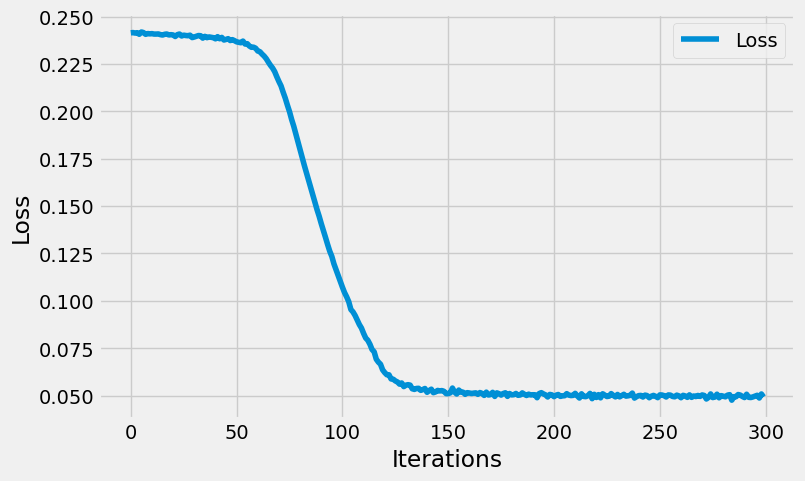

In [46]:
epochs = 100
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in dataloader:
        # images = images.view(-1, 128 * 128).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Sample a batch
model.eval()
dataiter = iter(dataloader)
original_images, labels = next(dataiter)  # original_images: [B, C, H, W]
labels_np = labels.cpu().numpy()

# Get latent representation vectors (using your model's encoder)
with torch.no_grad():
    encoded_vectors = model.encoder(original_images)  # Example: output shape [B, latent_dim]
encoded_vectors_np = encoded_vectors.cpu().numpy()

# Flatten the representation vectors if needed
X_flat = encoded_vectors_np.reshape(encoded_vectors_np.shape[0], -1)

print("Encoded representation shape:", encoded_vectors_np.shape)
print("Flattened representation shape:", X_flat.shape)
print("Labels shape:", labels_np.shape)

Encoded representation shape: (32, 128, 8, 8)
Flattened representation shape: (32, 8192)
Labels shape: (32,)


In [48]:
def preprocess(representations, labels, original_imgs, test_size=0.35, random_state=22):
    x_train, x_test, y_train, y_test, orig_train, orig_test = train_test_split(
        representations, labels, original_imgs, test_size=test_size, random_state=random_state
    )
    print("\nX-train shape:", x_train.shape)
    print("Y-train shape:", y_train.shape)
    print("\nX-test shape:", x_test.shape)
    print("Y-test shape:", y_test.shape)
    return x_train, y_train, x_test, y_test, orig_train, orig_test

x_train, y_train, x_test, y_test, orig_train, orig_test = preprocess(X_flat, labels_np, original_images)


X-train shape: (20, 8192)
Y-train shape: (20,)

X-test shape: (12, 8192)
Y-test shape: (12,)


In [49]:
def Kernel_SVM_train(X, y, lbl):
    # Map labels: if equal to lbl then -1, else 1, and reshape to column vector.
    y = np.where(y == lbl, -1, 1).reshape(-1, 1)
    g = 1/(X.shape[0] * X.var())
    alpha = 1e-8
    u1 = 1
    # Compute the polynomial kernel (X is assumed to be shape: (n_samples, n_features))
    K = polynomial_kernel(X, degree=2, gamma=g)
    
    # Create diagonal matrix with y values
    Y = np.diagflat(y.ravel())
    
    # Initialize L with dynamic size (n_samples, 1)
    n_samples = X.shape[0]
    L = np.random.randn(n_samples, 1)
    
    for i in range(18000000):
        grad = grad_f(L, Y, K, u1, y)
        L = L - alpha * grad
        if i % 100000 == 0:
            print(f"Iteration {i}, grad = {np.sum(grad)}")
    return K, L, g

def Kernel_SVM_predict(K, L, y, lbl):
    y = np.where(y == lbl, -1, 1).reshape(-1, 1)
    # Compute predictions
    y_hat = K @ (L * y)
    # Find indices for negative and positive classes
    neg_idx = np.where(y.ravel() == -1)[0]
    pos_idx = np.where(y.ravel() == 1)[0]

    neg_side = np.max(y_hat[neg_idx])
    pos_side = np.min(y_hat[pos_idx])
    b = (pos_side + neg_side) / 2

    y_hat = np.sign(K @ (L * y) + b)
    print("Accuracy on Training Data: ", accuracy_score(y, y_hat))
    return y_hat, b

def grad_f(L, Y, K, u1, y):
    n = L.shape[0]
    dL = np.zeros((n, 1))
    mask = L.flatten() < 0  
    dL[mask, 0] = -1
    df = Y @ K @ Y @ L + 2 * u1 * (L.T @ y) * y - np.ones((n, 1)) + dL
    return df


In [50]:
print("Starting Kernel_SVM...")
K, L, g = Kernel_SVM_train(x_train, y_train, 0)
preds = Kernel_SVM_predict(K, L, y_train, 0)
print("Success")

Starting Kernel_SVM...
Iteration 0, grad = -3014881.7167053926
Iteration 100000, grad = -442.2048712373251
Iteration 200000, grad = -109.81667225547766
Iteration 300000, grad = 49.30389407880641
Iteration 400000, grad = 116.40693956393523
Iteration 500000, grad = 138.55006049089886
Iteration 600000, grad = 140.54838962350817
Iteration 700000, grad = 134.71598445750902
Iteration 800000, grad = 126.70830611137167
Iteration 900000, grad = 116.80777673226544
Iteration 1000000, grad = 108.352984879317
Iteration 1100000, grad = 100.75942924638392
Iteration 1200000, grad = 94.08199519100165
Iteration 1300000, grad = 87.4288818053158
Iteration 1400000, grad = 81.54584610127954
Iteration 1500000, grad = 75.6968129205342
Iteration 1600000, grad = 71.43174466120135
Iteration 1700000, grad = 67.32231480896762
Iteration 1800000, grad = 63.453413891899004
Iteration 1900000, grad = 59.84347931119956
Iteration 2000000, grad = 56.48573900615541
Iteration 2100000, grad = 53.36464460281289
Iteration 2200

In [51]:
def Kernel_SVM_predict_test(x_test, x_train, L, y_train, y_test, gamma, degree=2):
    y_test = np.where(y_test == 0, -1, 1).reshape(-1, 1)
    y_train = np.where(y_train == 0, -1, 1).reshape(-1, 1)
    # Compute the kernel matrix between test and training train
    K_test = polynomial_kernel(x_test, x_train, degree=degree, gamma=gamma)
    
    # Compute decision values for the training train (to estimate bias b)
    K_train = polynomial_kernel(x_train, x_train, degree=degree, gamma=gamma)
    decision_train = K_train @ (L * y_train)
    
    # Estimate the bias b using training points
    neg_idx = np.where(y_train.ravel() == -1)[0]
    pos_idx = np.where(y_train.ravel() == 1)[0]
    
    # For a simple bias estimation, average the max decision value for negative class 
    # and the min decision value for positive class
    neg_side = np.max(decision_train[neg_idx])
    pos_side = np.min(decision_train[pos_idx])
    b = (pos_side + neg_side) / 2
    
    # Predict the labels for test train
    decision_test = K_test @ (L * y_train)
    y_pred = np.sign(decision_test + b)
    print("K-SVM accuracy on test train: ", accuracy_score(y_test, y_pred))
    return y_pred

pred = Kernel_SVM_predict_test(x_test, x_train, L, y_train, y_test, g, degree=2)

K-SVM accuracy on test data:  0.8333333333333334


There are 6 images in the "good" labelled data that I think are misclassified. There are 1-3 images in the "bad" labelled dataset that I think are misclassified. There are 42 images in each set. I don't know if this is a coincidence, but 6/42 = 0.85714, which is the highest accuracy I have accomplished on the test data.

/var/folders/pb/py28cd715ys4kc9v_fjgqt1c0000gn/T/ipykernel_54177/2353843338.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int((y_pred[idx] + 1) // 2)
/var/folders/pb/py28cd715ys4kc9v_fjgqt1c0000gn/T/ipykernel_54177/2353843338.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int((y_true[idx] + 1) // 2)


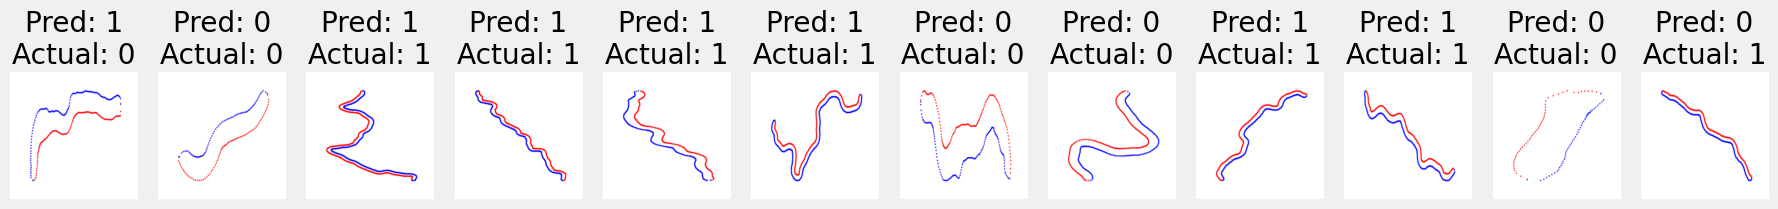

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(original_images, y_true, y_pred):
    """
    Display original images with predicted and actual labels in a grid.
    
    Parameters:
    - original_images: array of original images (shape: [n, H, W, C] or [n, C, H, W])
    - y_true: true labels in {-1, 1} (will be mapped to 0 and 1 for display)
    - y_pred: predicted labels in {-1, 1} (will be mapped to 0 and 1 for display)
    """
    num_images = len(original_images)
    
    # Determine grid dimensions (roughly square)
    ncols = int(np.ceil(np.sqrt(num_images)))
    nrows = int(np.ceil(num_images / ncols))
    
    plt.figure(figsize=(ncols * 3, nrows * 3))
    
    for i in range(num_images):
        plt.subplot(nrows, ncols, i + 1)
        # Get the original image
        img = original_images[i]
        # If the image is in tensor format with channels first, convert to channels last
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
        plt.axis('off')
        
        # Map predictions and true labels from {-1,1} to {0,1} for display.
        # Use .item() to extract a Python scalar and avoid warnings.
        pred_val = (y_pred[i] + 1) // 2
        true_val = (y_true[i] + 1) // 2
        pred_label = int(pred_val.item() if isinstance(pred_val, np.ndarray) else pred_val)
        true_label = int(true_val.item() if isinstance(true_val, np.ndarray) else true_val)
        
        plt.title(f"Pred: {pred_label}\nActual: {true_label}", fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming orig_test is a PyTorch tensor of original test images.
# Convert to numpy array if needed.
# y_test_binary should be in {-1, 1} and pred should be the predictions in {-1, 1}.
# show_predictions(orig_test.numpy(), y_test_binary, pred)